In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

from flax import nnx
from jax import random
import jax.numpy as jnp

import numpyro
from numpyro.contrib.module import nnx_module
import numpyro.distributions as dist
from numpyro.handlers import condition
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.util import Predictive

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/Documents/envs/numpyro-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n = 32 * 10
rng_key, rng_subkey = random.split(rng_key)
x = jnp.linspace(1, jnp.pi, n)
mu_true = jnp.sqrt(x + 0.5) * jnp.sin(9 * x)
sigma_true = 0.15 * x**2
rng_key, rng_subkey = random.split(rng_key)
y = mu_true + sigma_true * random.normal(rng_key, shape=(n,))

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

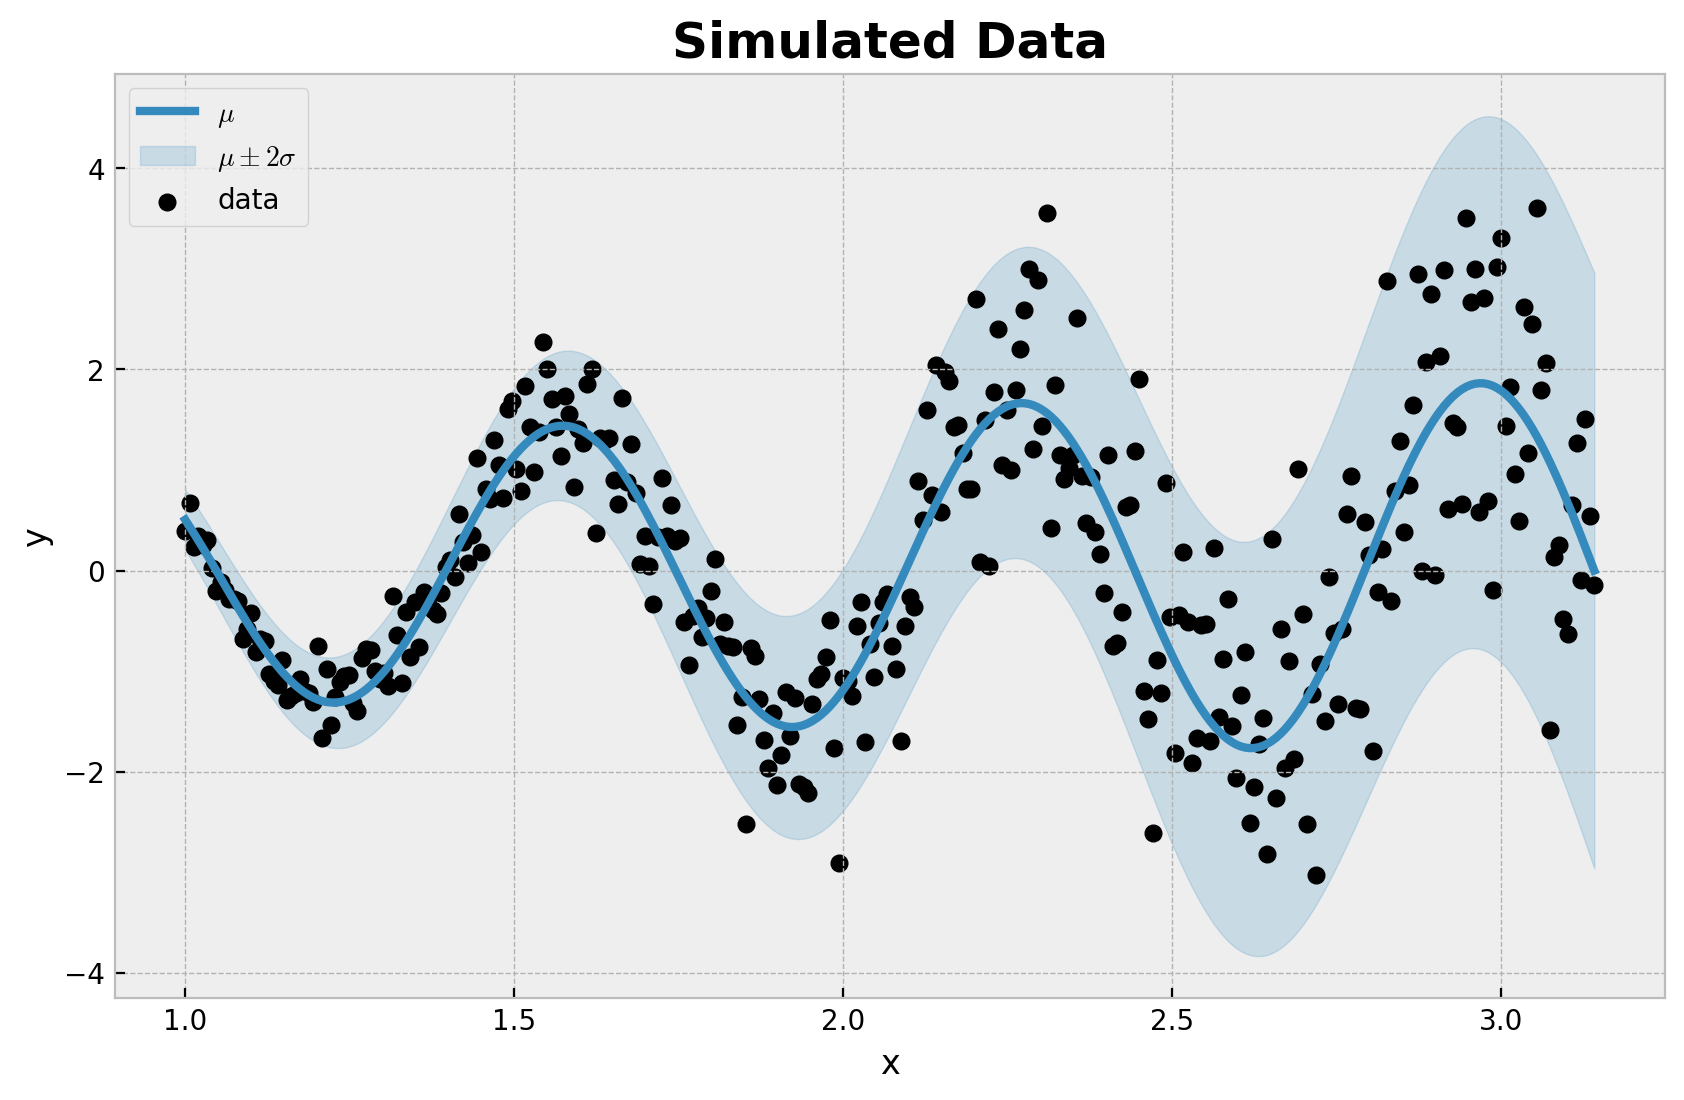

In [3]:
fig, ax = plt.subplots()
ax.plot(x, mu_true, color="C0", label=r"$\mu$", linewidth=3)
ax.fill_between(
    x,
    (mu_true - 2 * sigma_true),
    (mu_true + 2 * sigma_true),
    color="C0",
    alpha=0.2,
    label=r"$\mu \pm 2 \sigma$",
)
ax.scatter(x, y, color="black", label="data")
ax.legend(loc="upper left")
ax.set_title(label="Simulated Data", fontsize=18, fontweight="bold")
ax.set(xlabel="x", ylabel="y")

In [4]:
x_train = x[..., None]
y_train = y

In [5]:
class MLP(nnx.Module):
    def __init__(self, din: int, dmid: int, dout: int, *, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(din, dmid, rngs=rngs)
        self.linear2 = nnx.Linear(dmid, dout, rngs=rngs)

    def __call__(self, x, rngs=None):
        x = self.linear1(x)
        x = nnx.sigmoid(x)
        x = self.linear2(x)
        return x

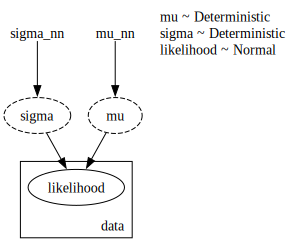

In [32]:
def model(x, y=None):
    mu_nn = nnx_module("mu_nn", MLP, din=1, dmid=32, dout=1, input_shape=(1,))
    log_sigma_nn = nnx_module("sigma_nn", MLP, din=1, dmid=8, dout=1, input_shape=(1,))

    mu = numpyro.deterministic("mu", mu_nn(x).squeeze())

    sigma = numpyro.deterministic("sigma", jnp.exp(log_sigma_nn(x)).squeeze())

    with numpyro.plate("data", len(x)):
        numpyro.sample("likelihood", dist.Normal(loc=mu, scale=sigma))


numpyro.render_model(
    model=model,
    model_args=(x_train, y_train),
    render_distributions=True,
    render_params=True,
)

100%|██████████| 10000/10000 [00:01<00:00, 8677.62it/s, init loss: 694.5445, avg. loss [9501-10000]: 363.0435]


Text(0.5, 1.0, 'ELBO loss')

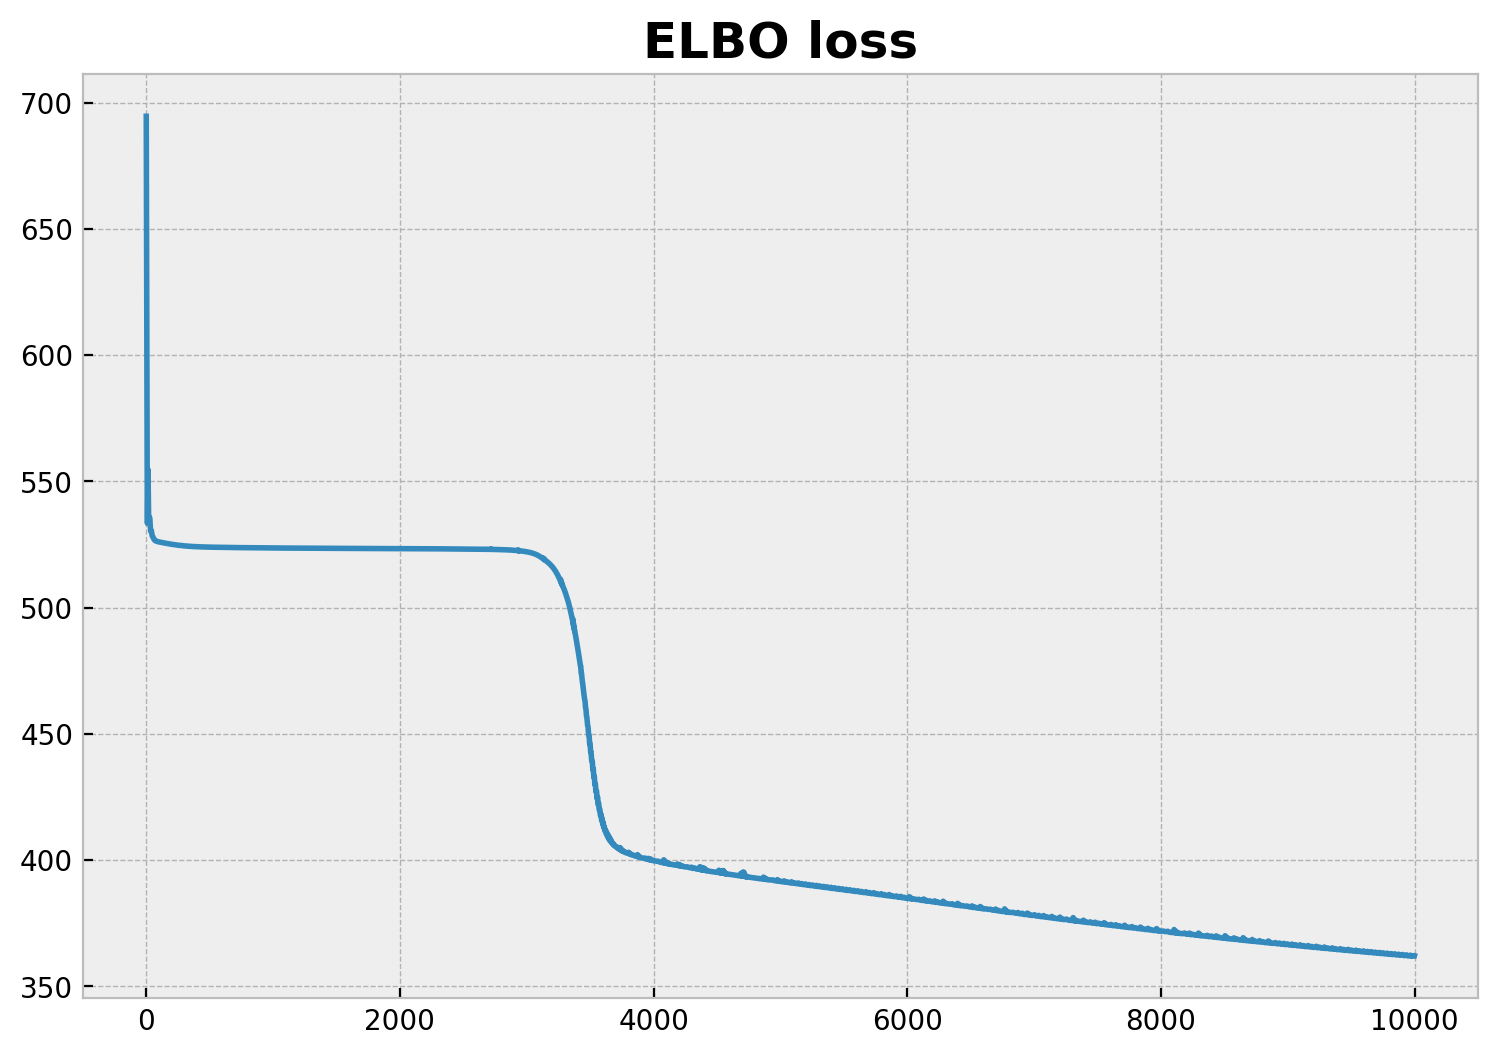

In [33]:
conditioned_model = condition(model, data={"likelihood": y_train})

guide = AutoNormal(model=conditioned_model)
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(conditioned_model, guide, optimizer, loss=Trace_ELBO())
n_samples = 10_000
rng_key, rng_subkey = random.split(key=rng_key)
svi_result = svi.run(rng_subkey, n_samples, x_train, y_train)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold")

In [34]:
params = svi_result.params
# get posterior predictive (deterministics and likelihood)
posterior_predictive = Predictive(
    model=model, guide=guide, params=params, num_samples=4 * 4_000
)
rng_key, rng_subkey = random.split(key=rng_key)
posterior_predictive_samples = posterior_predictive(rng_subkey, x_train, y_train)

In [35]:
obs_train = jnp.arange(x_train.size)

In [36]:
idata_svi = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_predictive_samples.items()
    },
    coords={"obs": obs_train},
    dims={"mu": ["obs"], "sigma": ["obs"], "likelihood": ["obs"]},
)

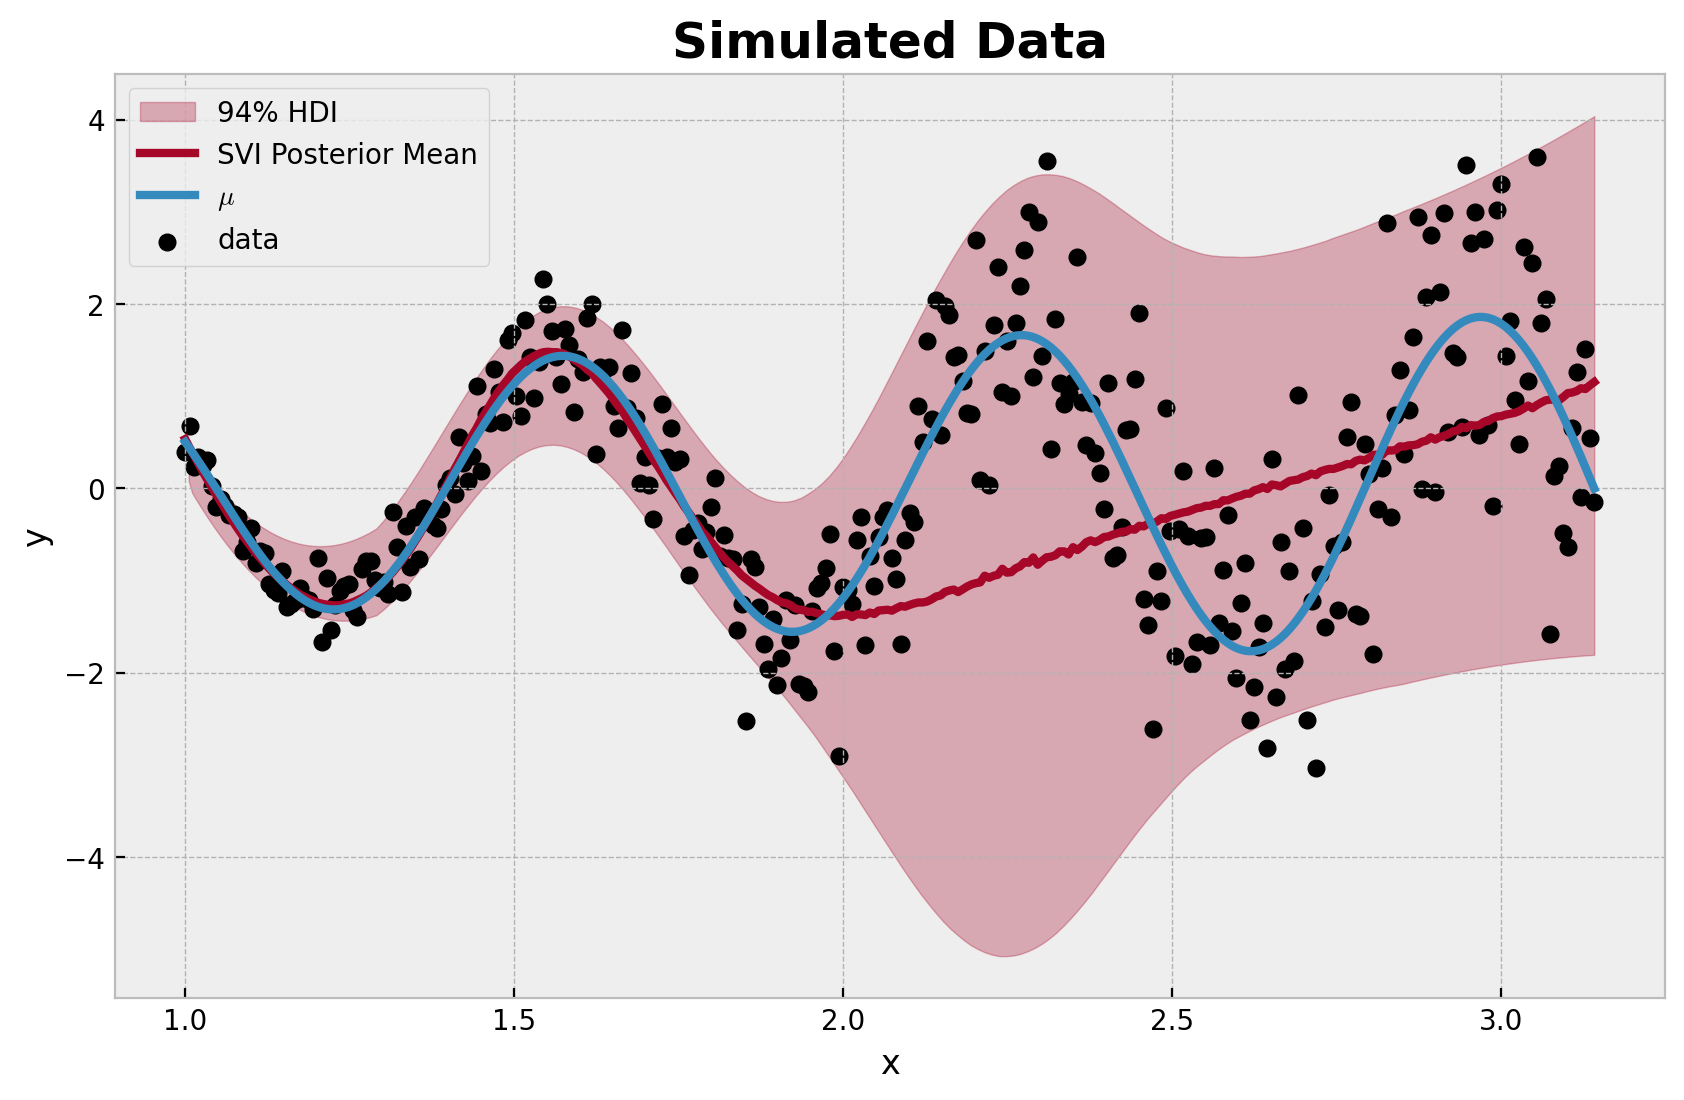

In [37]:
fig, ax = plt.subplots()
az.plot_hdi(
    x,
    idata_svi["posterior_predictive"]["likelihood"],
    color="C1",
    fill_kwargs={"alpha": 0.3, "label": "94% HDI"},
    ax=ax,
)
ax.plot(
    x_train,
    idata_svi["posterior_predictive"]["likelihood"].mean(dim=("chain", "draw")),
    color="C1",
    linewidth=3,
    label="SVI Posterior Mean",
)
ax.plot(x, mu_true, color="C0", label=r"$\mu$", linewidth=3)
ax.scatter(x, y, color="black", label="data")
ax.legend(loc="upper left")
ax.set_title(label="Simulated Data", fontsize=18, fontweight="bold")
ax.set(xlabel="x", ylabel="y");